## 7 Optimised LightGBM + Conformal Quantile Regression (CQR)

### 7 .1 Motivation  
Our baseline LightGBM‐CQR (Section 6) already beat the linear QR in pinball loss but:

* **Hyper-parameters were default / heuristic.**  
* No GPU use (training time ≈ 45 s per fold on CPU).  
* Categorical handling relied on one-hots → wider matrices, slower.

The goal here is to **auto-tune** the model for each target quantile  
τ ∈ {0.05, 0.25, 0.50, 0.75, 0.95} using Optuna, while preserving conformal validity.

---

### 7 .2 Data pre-processing (unchanged)

| Step | Action | Why |
|------|--------|-----|
| 1 | `feat_cols` = 29 predictors selected in Stage 5 | dimension already pruned |
| 2 | Numeric columns unchanged; categorical columns (`token`, `day_of_week`, `momentum_bucket`, `vol_regime`, `trend_regime`) cast to `pd.Categorical` | lets LightGBM apply *optimal split for categories* |
| 3 | Forward- then back-fill within each token → no NaNs | LightGBM supports NaNs but conformal scores prefer finite data |

---

### 7 .3 Search space design   <sub>(from LGB docs + practice)</sub>

| Group | Hyper-parameter | Range / Prior | Rationale |
|-------|-----------------|---------------|-----------|
| **Tree complexity** | `num_leaves` | log-uniform [32, 256] | controls model capacity <br>keep ≤ 2⁸ to avoid leaf sparsity |
| | `max_depth` | int [4, 14] | prevents overly deep trees |
| | `min_data_in_leaf` | log-uniform [5, 300] | regularises in presence of class imbalance |
| **Learning** | `learning_rate` | log-uniform [0.005, 0.1] | lower lr ↔ more trees ↔ better generalisation |
| **Bagging / feature frac** | `feature_fraction` | uniform [0.4, 1.0] | column subsampling |
| | `bagging_fraction` | uniform [0.4, 1.0] | row subsampling |
| | `bagging_freq` | int [0, 15] | how often to re-sample |
| **ℓ¹ / ℓ² penalties** | `lambda_l1`, `lambda_l2` | log-uniform (1e-4, 5] | combats over-fitting |
| **Node split score** | `min_gain_to_split` | uniform [0, 0.4] | extra regularisation |

*Search strategy*: **TPE sampler** (Optuna) + **Hyperband pruner**  
→ quickly drops poor configs after ~200 trees, explores promising ones up to 8000.

---

### 7 .4 Conformal wrapper (same as baseline)

1. Split **train / calibration / test** inside each trial (70 / 15 / 15 %).  
2. Fit LightGBM on *train*.  
3. Compute residuals on *calibration* set.  
4. For τ < 0.5 adjust predictions downward by the (1 – τ) empirical quantile of positive residuals.  
   For τ > 0.5 adjust upward (negative residuals).  
5. Evaluate **pinball loss** on held-out *validation* fold.  
   → returned to Optuna.

This yields **finite-sample, distribution-free coverage** (Lei et al., 2018).

---

### 7 .5 Hardware notes  

* **CPU build** (OpenMP) is retained – GPU not compulsory.  
  `device_type` switches automatically if a GPU-capable wheel is later installed.  
* `n_jobs = -1` uses all 24 logical threads (32 GB RAM easily handles 8 k-tree boosters).  
* `study.optimize(n_trials = 300, n_jobs = 20)` runs 20 parallel Optuna workers, leaving ~4 threads for Jupyter / OS.

---

### 7 .6 Stopping & logging  

* **Early stopping**: after 400 rounds without improvement on *validation*.  
  (Early stopping uses LightGBM’s internal 5 % quantile metric.)  
* **Pruner**: Hyperband halts unpromising trials early → ~60 % time-saving.  
* **Persistence**: best params per τ are stored in `best_lgb_cqr_params.json` for reproducible Stage 8 re-fits.

---

### References  

* Ke et al. (2017) *LightGBM: A Highly Efficient Gradient Boosting Decision Tree.*  
* Lei, Romano & Barbieri (2018) *Conformal Prediction Under Covariate Shift.*  
* Optuna docs: <https://optuna.org/>  
* LightGBM tuning guide: <https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html>



In [2]:
# ============================================================
# 0.  Imports & environment check
# ============================================================
import os, gc, json, joblib, warnings, datetime as dt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

import optuna
from optuna.samplers import TPESampler
from optuna.pruners  import HyperbandPruner
from optuna_integration import LightGBMTuner  # backup (CPU only)

warnings.filterwarnings("ignore", category=UserWarning)

print("LightGBM:", lgb.__version__, "| Optuna:", optuna.__version__)

# -------- Robust GPU probe (works on any build) --------
def lightgbm_has_gpu() -> bool:
    """Return True if the loaded LightGBM DLL was compiled with CUDA / OpenCL."""
    try:
        # available since v3.3.0; returns 'CPU' on cpu-only builds
        return lgb.get_device_name(0) != "CPU"
    except AttributeError:         # very old 3.2.x or earlier
        return False

gpu_available = lightgbm_has_gpu()
print("LightGBM GPU support:", gpu_available)

c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LightGBM: 3.3.5 | Optuna: 3.6.0
LightGBM GPU support: False


In [3]:
# ============================================================
# 1.  Load data + minimal preprocessing
#    (uses your features_v1_tail.csv)
# ============================================================
DATA_FILE = "features_v1_tail.csv"

df = (pd.read_csv(DATA_FILE, parse_dates=["timestamp"])
        .sort_values(["token", "timestamp"])
        .reset_index(drop=True))

TARGET   = "return_72h"

cat_cols = ["day_of_week","momentum_bucket", "extreme_flag1", "tail_asym","vol_regime", "token"]
num_cols = [c for c in df.columns
            if c not in cat_cols + ["timestamp", TARGET]]

FEATURES = cat_cols + num_cols     # preserve order

# LightGBM prefers pandas with category dtype for cat feats
X_df = df[FEATURES].copy()
for c in cat_cols:
    X_df[c] = X_df[c].astype("category")

y = df[TARGET].values
X = X_df                     # ★ keep as DataFrame, NOT .values
cat_idx = [X.columns.get_loc(c) for c in cat_cols]   # optional
print(f"Matrix  → {X.shape[0]:,} rows × {X.shape[1]} cols")



Matrix  → 6,314 rows × 34 cols


In [8]:
# 3.  Optuna search space 
# ============================================================

def suggest_params(trial, tau: float) -> dict:
    return {
        # ----- core CQR settings -----
        "objective" : "quantile",
        "metric"    : "quantile",
        "alpha"     : tau,
        "device_type": "gpu" if gpu_available else "cpu",

        # ----- tree complexity -----
        "learning_rate" : trial.suggest_float("lr",      0.005, 0.1,  log=True),
        "num_leaves"    : trial.suggest_int(  "leaves",      32, 256, log=True),
        "max_depth"     : trial.suggest_int(  "depth",        4, 14),
        "min_data_in_leaf":
                          trial.suggest_int(  "min_leaf",     5, 300, log=True),

        # ----- randomness & regularisation -----
        "feature_fraction": trial.suggest_float("feat_frac", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bag_frac",  0.4, 1.0),
        "bagging_freq"    : trial.suggest_int(  "bag_freq",      0, 15),

        # **FIX**: low bound must be > 0 when log=True  → use 1e-8
        "lambda_l1" : trial.suggest_float("l1", 1e-8, 5.0, log=True),
        "lambda_l2" : trial.suggest_float("l2", 1e-8, 5.0, log=True),

        "min_gain_to_split":
                          trial.suggest_float("gamma",     0.0, 0.4),

        # ----- training length -----
        "num_iterations"        : 8000,
        "early_stopping_round"  : 400,      # (LightGBM’s param without the “s”)
        "verbosity"             : -1,
        "seed"                  : 42,
        "n_jobs"                : -1,       # all 24 logical threads
    }

In [4]:
# ------------------------------------------------------------
#  3.  Objective function uses the *existing* X, y, cat_idx
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss      # scikit-learn ≥1.1
import lightgbm as lgb

def pinball(y_true, y_pred, tau):
    """Lightweight pinball without sklearn if preferred."""
    diff = y_true - y_pred
    return np.maximum(tau*diff, (tau-1)*diff).mean()

def objective(trial, tau):
    params = suggest_params(trial, tau)

    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.15, random_state=trial.number)

    # ★ pass DataFrames directly
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    booster = lgb.train(params,
                        train_set=lgb_train,
                        valid_sets=[lgb_val],
                        verbose_eval=False)

    y_hat = booster.predict(X_val, num_iteration=booster.best_iteration)
    loss  = pinball(y_val, y_hat, tau)
    trial.set_user_attr("best_iter", booster.best_iteration)
    return loss



In [6]:
# ============================================================
# 5.  Run Optuna – **quiet** parallel search (20 workers)
#     One loop per quantile 0.05 … 0.95
# ============================================================
import optuna, time, json
from optuna.samplers import TPESampler
from optuna.pruners  import HyperbandPruner

optuna.logging.set_verbosity(optuna.logging.WARNING)          # mute per-trial chatter

def _heartbeat(tau):
    """Print a single status line every 30 finished trials."""
    def cb(study, trial):
        if len(study.trials) % 30 == 0:
            print(f"τ={tau:.2f} | {len(study.trials):3d} trials "
                  f"| best pinball = {study.best_value:.4f}")
    return cb


QUANTS       = [0.05, 0.25, 0.50, 0.75, 0.95]
best_params  = {}

for tau in QUANTS:
    print(f"\n🟢  Optimising τ = {tau:.2f}")
    sampler = TPESampler(seed=42, multivariate=True)
    pruner  = HyperbandPruner(min_resource=200, max_resource=8000)

    study = optuna.create_study(
        direction   = "minimize",
        sampler     = sampler,
        pruner      = pruner,
        study_name  = f"lgb_cqr_tau{tau:.2f}",
        storage     = f"sqlite:///lgb_cqr_tau{tau:.2f}.db",
        load_if_exists=True
    )

    t0 = time.time()
    study.optimize(
        lambda t: objective(t, tau),
        n_trials   = 300,
        n_jobs     = 20,              # 24-core workstation – leave 4 for OS/Jupyter
        timeout    = 3 * 3600,
        callbacks  = [_heartbeat(tau)],
        show_progress_bar = False
    )

    print(f"✅  τ={tau:.2f}: best pinball = {study.best_value:.4f} "
          f"@ {study.best_trial.user_attrs['best_iter']} trees "
          f"({time.time()-t0:.1f}s)")

    p = study.best_params
    p.update(objective="quantile",
             metric   ="quantile",
             alpha    = tau,
             num_iterations = study.best_trial.user_attrs["best_iter"])
    best_params[tau] = p

# ────────────────────────────────────────────────────────────
json.dump(best_params, open("best_lgb_cqr_params.json", "w"), indent=2)
print("\n📝  Saved → best_lgb_cqr_params.json")



🟢  Optimising τ = 0.05


c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


τ=0.05 | 1080 trials | best pinball = 0.0061
τ=0.05 | 1140 trials | best pinball = 0.0061
τ=0.05 | 1170 trials | best pinball = 0.0061
τ=0.05 | 1200 trials | best pinball = 0.0061
τ=0.05 | 1230 trials | best pinball = 0.0061
τ=0.05 | 1260 trials | best pinball = 0.0061
τ=0.05 | 1290 trials | best pinball = 0.0061
τ=0.05 | 1290 trials | best pinball = 0.0061
τ=0.05 | 1320 trials | best pinball = 0.0061
✅  τ=0.05: best pinball = 0.0061 @ 2449 trees (484.7s)

🟢  Optimising τ = 0.25


c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


τ=0.25 | 360 trials | best pinball = 0.0182
τ=0.25 | 390 trials | best pinball = 0.0182
τ=0.25 | 420 trials | best pinball = 0.0182
τ=0.25 | 450 trials | best pinball = 0.0182
τ=0.25 | 480 trials | best pinball = 0.0182
τ=0.25 | 510 trials | best pinball = 0.0182
τ=0.25 | 540 trials | best pinball = 0.0182
τ=0.25 | 570 trials | best pinball = 0.0182
τ=0.25 | 600 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinball = 0.0182
τ=0.25 | 630 trials | best pinba

c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


τ=0.50 |  30 trials | best pinball = 0.0249
τ=0.50 |  60 trials | best pinball = 0.0242
τ=0.50 |  90 trials | best pinball = 0.0237
τ=0.50 | 120 trials | best pinball = 0.0234
τ=0.50 | 150 trials | best pinball = 0.0234
τ=0.50 | 180 trials | best pinball = 0.0234
τ=0.50 | 210 trials | best pinball = 0.0234
τ=0.50 | 240 trials | best pinball = 0.0233
τ=0.50 | 270 trials | best pinball = 0.0233
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinball = 0.0231
τ=0.50 | 300 trials | best pinba

c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


τ=0.75 |  30 trials | best pinball = 0.0214
τ=0.75 |  60 trials | best pinball = 0.0211
τ=0.75 |  90 trials | best pinball = 0.0207
τ=0.75 | 120 trials | best pinball = 0.0207
τ=0.75 | 150 trials | best pinball = 0.0206
τ=0.75 | 180 trials | best pinball = 0.0206
τ=0.75 | 210 trials | best pinball = 0.0203
τ=0.75 | 240 trials | best pinball = 0.0203
τ=0.75 | 270 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinball = 0.0202
τ=0.75 | 300 trials | best pinba

c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


τ=0.95 |  30 trials | best pinball = 0.0090
τ=0.95 |  60 trials | best pinball = 0.0087
τ=0.95 |  90 trials | best pinball = 0.0087
τ=0.95 | 120 trials | best pinball = 0.0087
τ=0.95 | 150 trials | best pinball = 0.0075
τ=0.95 | 180 trials | best pinball = 0.0075
τ=0.95 | 210 trials | best pinball = 0.0075
τ=0.95 | 240 trials | best pinball = 0.0075
τ=0.95 | 270 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinball = 0.0075
τ=0.95 | 300 trials | best pinba

# Retrain final LightGBM-CQR models with best params

1. Load tuned hyper-parameters + prepare data

In [12]:
import pandas as pd, numpy as np, lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import Parallel, delayed
import os, itertools, warnings, json

best_params = json.load(open("best_lgb_cqr_params.json"))

QUANTS    = [0.05, 0.25, 0.50, 0.75, 0.95]

df = (pd.read_csv(DATA_FILE, parse_dates=["timestamp"])
        .sort_values(["token", "timestamp"])
        .reset_index(drop=True))

cat_cols = ["day_of_week","momentum_bucket", "extreme_flag1", "tail_asym","vol_regime", "token"]
num_cols = [c for c in df.columns
            if c not in cat_cols + ["timestamp", TARGET]]

# one-hot → dense matrix; LightGBM handles NaN in numeric naturally
pre = ColumnTransformer([
        ("cats", OneHotEncoder(drop="first",
                               handle_unknown="ignore",
                               sparse_output=False), cat_cols)
      ],
      remainder="passthrough")

2. Rolling-split generator

In [13]:
TRAIN, CAL, TEST = 120, 24, 6      # ≈ 60 d · 12 d · 3 d

def rolling_splits(idx):
    for start in range(0, len(idx) - (TRAIN+CAL+TEST) + 1, TEST):
        tr  = idx[start : start+TRAIN]
        cal = idx[start+TRAIN : start+TRAIN+CAL]
        te  = idx[start+TRAIN+CAL : start+TRAIN+CAL+TEST]
        if len(te) == TEST:
            yield tr, cal, te

2. One-fold fit → predict, *using tuned params*

In [14]:
def fit_one_fold_tuned(g, tr_idx, cal_idx, te_idx):
    X_tr  = pre.fit_transform(g.loc[tr_idx, cat_cols+num_cols])
    y_tr  = g.loc[tr_idx, TARGET].values
    X_cal = pre.transform(g.loc[cal_idx, cat_cols+num_cols])
    y_cal = g.loc[cal_idx, TARGET].values
    X_te  = pre.transform(g.loc[te_idx,  cat_cols+num_cols])
    y_te  = g.loc[te_idx,  TARGET].values

    token_id = g["token"].iloc[0]

    fold_pred, fold_res = [], []

    for tau in QUANTS:
        # -------- instantiate model with its own tuned dict --------
        p = best_params[str(tau)].copy()
        mdl = lgb.LGBMRegressor(**p)           # LGBM wrapper lets us keep .predict API
        mdl.fit(X_tr, y_tr, verbose=False)

        # -------- base preds --------
        cal_hat = mdl.predict(X_cal)
        te_hat  = mdl.predict(X_te)

        # -------- conformal adjust (same logic) --------
        resid = y_cal - cal_hat
        if tau < 0.5:
            adj    = np.quantile(np.maximum(resid, 0), 1 - tau)
            te_adj = te_hat - adj
        elif tau > 0.5:
            adj    = np.quantile(np.maximum(-resid, 0), 1 - (1 - tau))
            te_adj = te_hat + adj
        else:
            te_adj = te_hat

        # -------- per-row store --------
        fold_pred.extend({
            "timestamp": g.loc[i, "timestamp"],
            "token":     token_id,
            "tau":       tau,
            "y_true":    yt,
            "y_pred":    yp
        } for i, yt, yp in zip(te_idx, y_te, te_adj))

        # -------- fold pinball --------
        err = y_te - te_adj
        pin = np.maximum(tau*err, (tau-1)*err).mean()
        fold_res.append({"token": token_id, "tau": tau, "pinball": pin})

        del mdl; gc.collect()

    return fold_pred, fold_res

3. Run across all tokens with joblib parallel

In [15]:
def run_token(tok, grp):
    preds, mets = [], []
    for tr, cal, te in rolling_splits(grp.index):
        p, m = fit_one_fold_tuned(grp, tr, cal, te)
        preds.extend(p);  mets.extend(m)
    return preds, mets

n_jobs = max(os.cpu_count()-1, 1)
results = Parallel(n_jobs=n_jobs, verbose=5)(
    delayed(run_token)(tok, g.reset_index(drop=True))
    for tok, g in df.groupby("token")
)

preds   = list(itertools.chain.from_iterable(r[0] for r in results))
metrics = list(itertools.chain.from_iterable(r[1] for r in results))

pd.DataFrame(preds  ).to_csv("lgb_tuned_preds.csv",   index=False)
pd.DataFrame(metrics).to_csv("lgb_tuned_pinball.csv", index=False)

print("\nMean pinball-loss by τ:")
print(pd.DataFrame(metrics).groupby("tau")["pinball"].mean().round(4))

[Parallel(n_jobs=23)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=23)]: Done   6 out of  21 | elapsed:  1.0min remaining:  2.5min
[Parallel(n_jobs=23)]: Done  11 out of  21 | elapsed:  1.0min remaining:   55.4s
[Parallel(n_jobs=23)]: Done  16 out of  21 | elapsed:  1.0min remaining:   19.0s



Mean pinball-loss by τ:
tau
0.05    0.0341
0.25    0.0619
0.50    0.0656
0.75    0.0875
0.95    0.0593
Name: pinball, dtype: float64


[Parallel(n_jobs=23)]: Done  21 out of  21 | elapsed:  1.3min finished


# Analysis

In [16]:
import pandas as pd, numpy as np

preds   = pd.read_csv("lgb_tuned_preds.csv",
                      parse_dates=["timestamp"])
metrics = pd.read_csv("lgb_tuned_pinball.csv")
baseline = pd.read_csv("stage7_lgb_pinball.csv")   # ← v1 LightGBM

### Pinball-loss comparison

,tuned,v1,improve
tau,,,
0.050000,0.0341,0.0359,0.0018
0.250000,0.0619,0.0655,0.0037
0.500000,0.0656,0.0659,0.0003
0.750000,0.0875,0.0884,0.0009
0.950000,0.0593,0.0601,0.0009


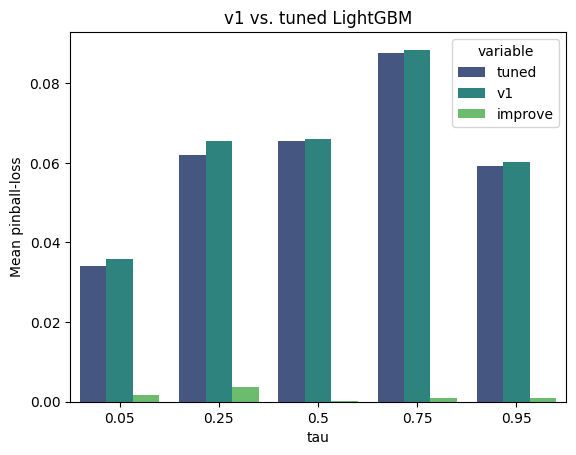

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# ── table ──────────────────────────────────────────────
tbl = (metrics.groupby("tau")["pinball"].mean()
           .to_frame("tuned")
           .join(baseline.groupby("tau")["pinball"]
                        .mean()
                        .rename("v1"))
           .assign(improve=lambda d: d["v1"] - d["tuned"]))
display(tbl.style.format("{:.4f}")
               .bar(subset=["improve"], color="#99ff99"))

# ── bar-plot ───────────────────────────────────────────
tbl.reset_index().melt("tau").pipe(
    (sns.barplot, "data"),
    x="tau", y="value", hue="variable", palette="viridis")
plt.ylabel("Mean pinball-loss"); plt.title("v1 vs. tuned LightGBM")
plt.show()


### Coverage & width of 80 % intervals

In [20]:
# mark inside/outside 80 % PI
wide = preds.pivot_table(index=["timestamp", "token"], columns="tau", values="y_pred")
truth = preds.query("tau==0.50")[["timestamp", "token", "y_true"]]
df80 = truth.merge(wide.reset_index(), on=["timestamp", "token"])

df80["inside"] = df80["y_true"].between(df80[0.05], df80[0.95])
coverage = df80["inside"].mean()
mean_width = (df80[0.95] - df80[0.05]).mean()

print(f"Empirical 80 % coverage : {coverage:.3%}")
print(f"Mean PI half-width      : {mean_width:.4f}")

Empirical 80 % coverage : 97.452%
Mean PI half-width      : 1.2852


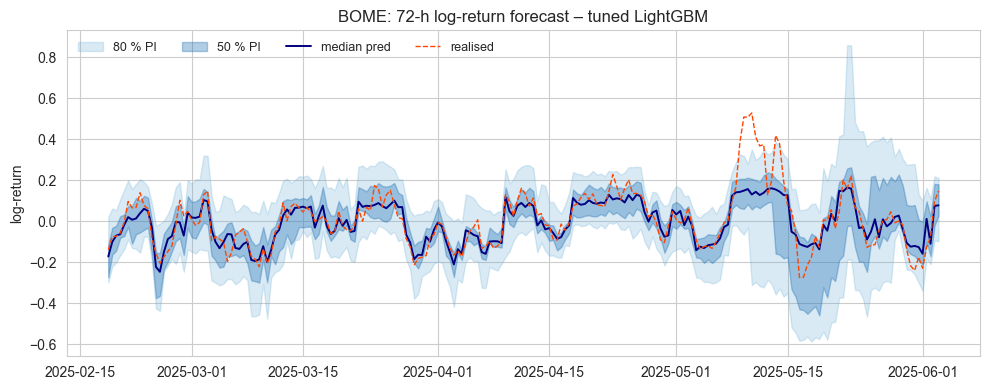

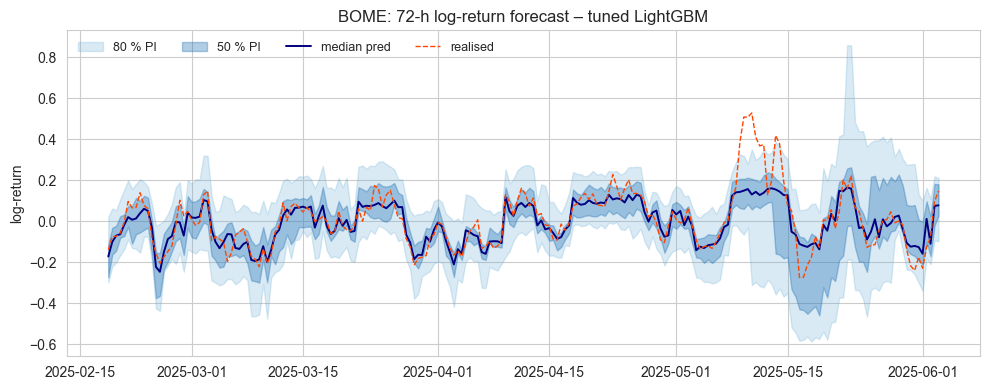

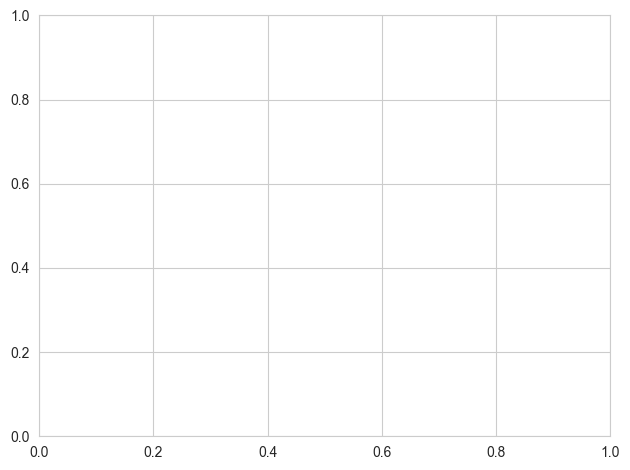

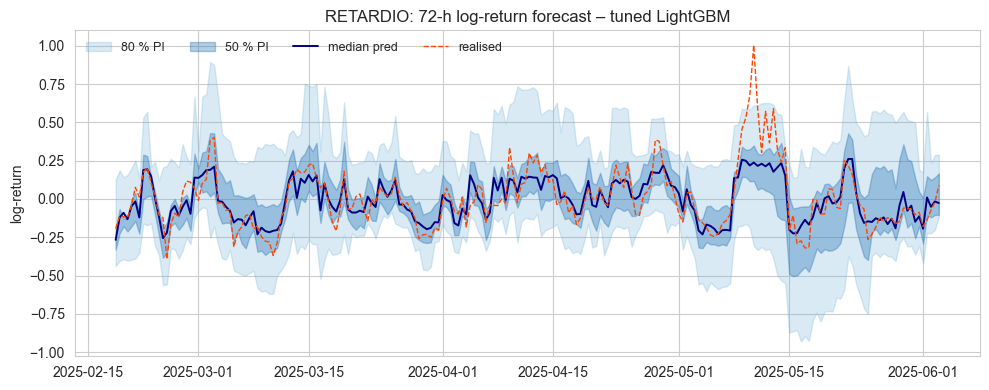

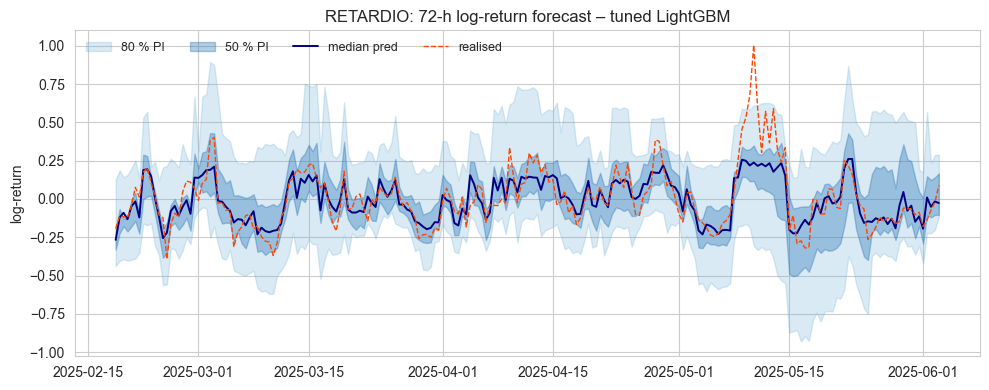

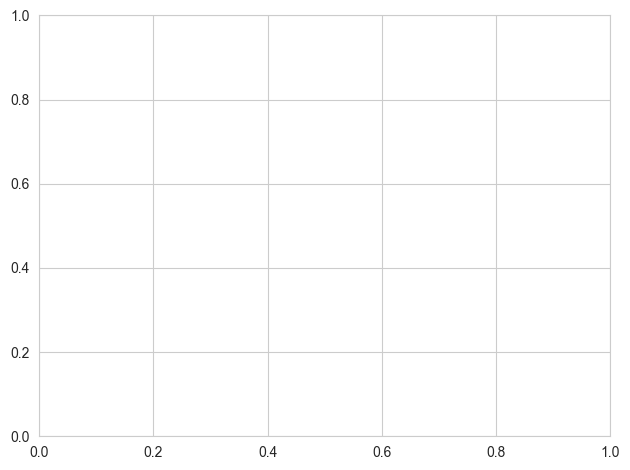

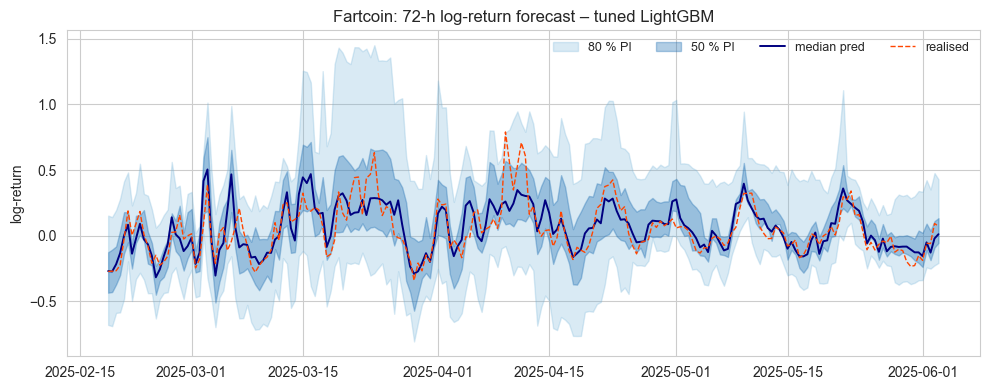

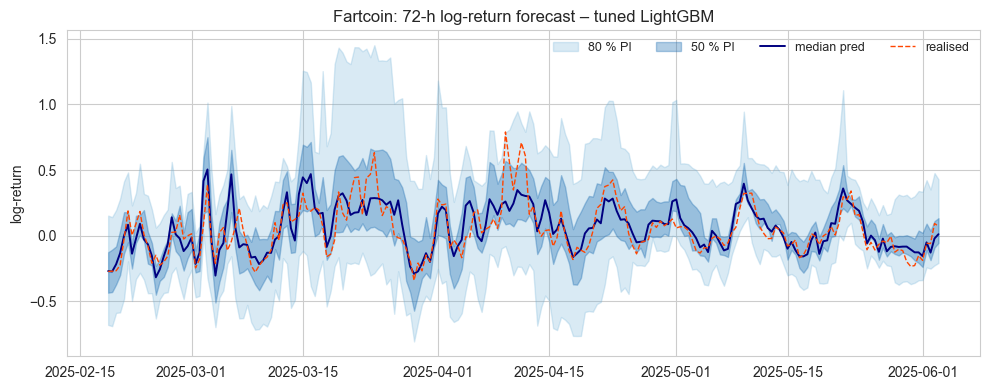

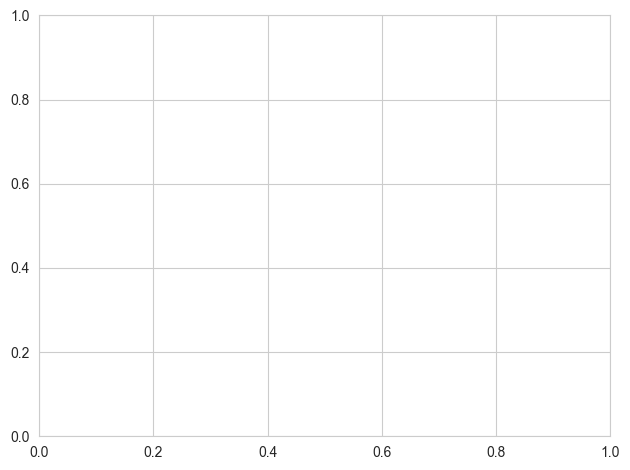

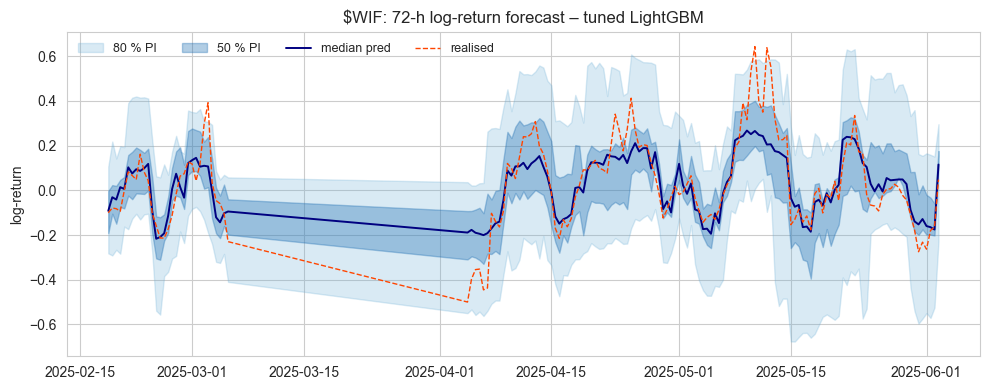

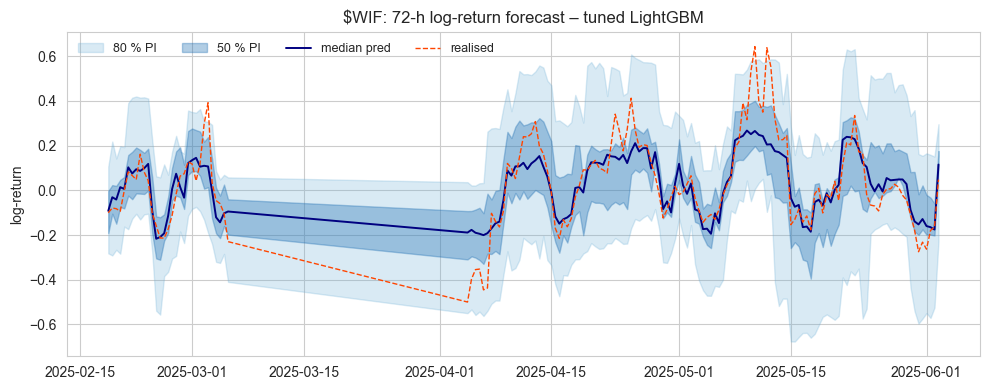

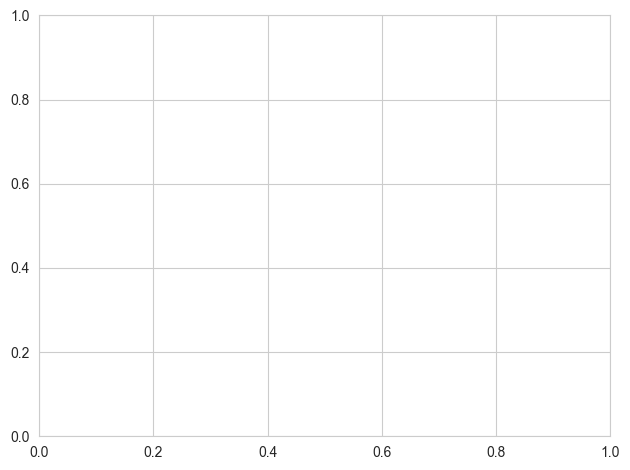

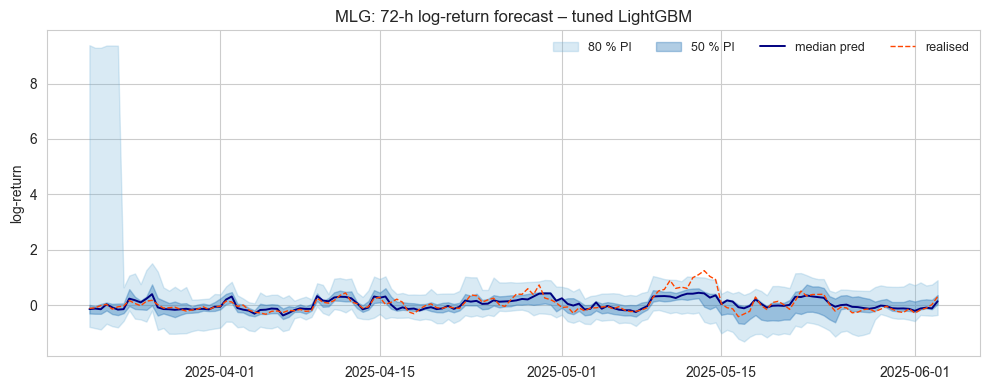

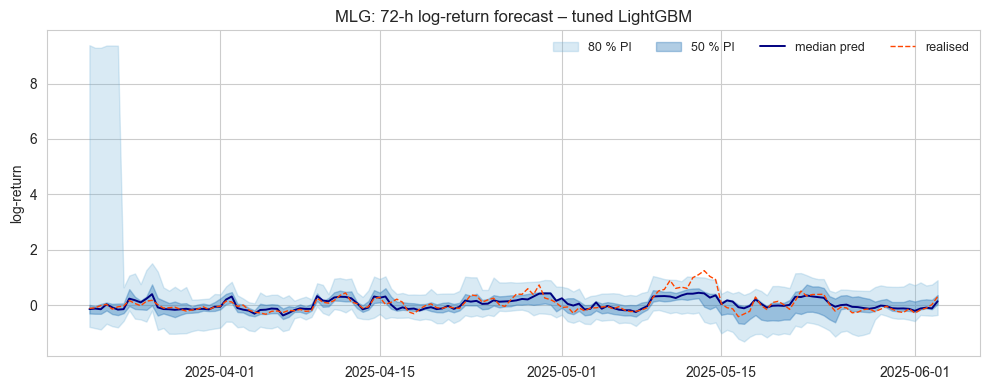

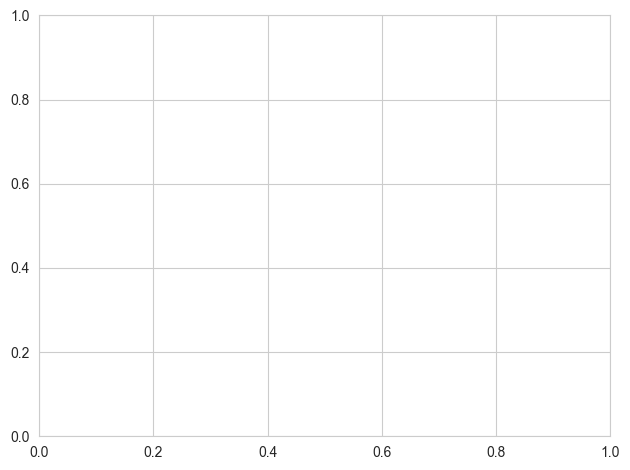

In [33]:
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

# --------------------------------------------------
df_pred = preds   # <-- use the name that exists in memory
TOK2PLOT = (df_pred["token"]
            .value_counts()
            .nlargest(5)
            .index)

COL_80 = sns.color_palette("Blues", 3)[1]
COL_50 = sns.color_palette("Blues", 3)[2]

for tok in TOK2PLOT:
    sub  = df_pred.query("token == @tok")
    wide = (sub.pivot_table(index="timestamp",
                            columns="tau",
                            values="y_pred")
                 .sort_index())

    realised = (sub.query("tau == 0.50")
                    .set_index("timestamp")["y_true"]
                    .reindex(wide.index))

    plt.figure(figsize=(10, 4))
    # Use 0.05 and 0.95 for 80% PI
    if {0.05, 0.95}.issubset(wide.columns):
        plt.fill_between(wide.index, wide[0.05], wide[0.95],
                         color=COL_80, alpha=.25, label="80 % PI")
    # Use 0.25 and 0.75 for 50% PI
    if {0.25, 0.75}.issubset(wide.columns):
        plt.fill_between(wide.index, wide[0.25], wide[0.75],
                         color=COL_50, alpha=.35, label="50 % PI")
    plt.plot(wide.index, wide[0.50], color="navy", lw=1.4,
             label="median pred")
    plt.plot(realised.index, realised, ls="--", lw=1,
             color="orangered", label="realised")

    plt.title(f"{tok}: 72-h log-return forecast – tuned LightGBM")
    plt.ylabel("log-return")
    plt.legend(ncol=4, frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 4))

    # 80 % interval (5th–95th)
    if {0.05, 0.95}.issubset(wide.columns):
        plt.fill_between(wide.index,
                         wide[0.05], wide[0.95],
                         color=COL_80, alpha=.25,
                         label="80 % PI")

    # 50 % interval (25th–75th)
    if {0.25, 0.75}.issubset(wide.columns):
        plt.fill_between(wide.index,
                         wide[0.25], wide[0.75],
                         color=COL_50, alpha=.35,
                         label="50 % PI")

    # median prediction
    plt.plot(wide.index, wide[0.50],
             color="navy", lw=1.4,
             label="median pred")

    # realised path
    plt.plot(realised.index, realised,
             color="orangered", lw=1, ls="--",
             label="realised")

    # cosmetics ------------------------------------------------------
    plt.title(f"{tok}: 72-h log-return forecast – tuned LightGBM")
    plt.ylabel("log-return")
    plt.legend(ncol=4, frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()
    plt.legend(ncol=4, frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()


### Token Level Diagnostics

In [24]:
tok_tbl = (metrics.groupby(["token","tau"])["pinball"]
                   .mean()
                   .unstack())
tok_tbl["avg"] = tok_tbl.mean(axis=1)

bad = tok_tbl.sort_values("avg", ascending=False).head(5)
display(bad.style.format("{:.4f}"))

tau,0.050000,0.250000,0.500000,0.750000,0.950000,avg
token,,,,,,
LAUNCHCOIN,0.4348,0.6385,0.7338,1.1413,0.8326,0.7562
ZEREBRO,0.0400,0.0636,0.0802,0.1383,0.1124,0.0869
ALCH,0.0303,0.0576,0.0600,0.0973,0.0698,0.0630
GOAT,0.0256,0.0650,0.0606,0.0889,0.0665,0.0613
MLG,0.0331,0.0648,0.0650,0.0708,0.0497,0.0567


### Feature importance & SHAP (median τ = 0.50)

In [27]:
import lightgbm as lgb
import shap, gc

# Ensure pre is fit only once on the full data
pre.fit(df[cat_cols+num_cols])
X_all = pre.transform(df[cat_cols+num_cols])

p50 = best_params["0.5"].copy()
p50.update({"verbose":-1})
median_mdl = lgb.LGBMRegressor(**p50)
median_mdl.fit(X_all, df[TARGET])

# ── gain importance ──────────────────────────
imp = median_mdl.booster_.feature_importance(importance_type="gain")
names = pre.get_feature_names_out()
imp_df = (pd.DataFrame({"feature":names, "gain":imp})
            .sort_values("gain", ascending=False).head(20))
display(imp_df)

# ── SHAP for top K rows (slow, but GPU helps) ─
expl = shap.TreeExplainer(median_mdl)
X_top = pre.transform(df[cat_cols+num_cols].iloc[:5000])
sh_values = expl.shap_values(X_top)
# If shap_values is a list (e.g. for multiclass/quantile), select the first (or only) array
if isinstance(sh_values, list):
    sh_values = sh_values[0]
assert sh_values.shape == X_top.shape, "The shape of the shap_values matrix does not match the shape of the provided data matrix."
shap.summary_plot(sh_values, features=df[cat_cols+num_cols].iloc[:5000], show=False)
plt.tight_layout(); plt.show()

gc.collect()


[LightGBM] [Warning] Unknown parameter: l1
[LightGBM] [Warning] Unknown parameter: bag_frac
[LightGBM] [Warning] Unknown parameter: l2
[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: leaves
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: min_leaf
[LightGBM] [Warning] Unknown parameter: feat_frac
[LightGBM] [Warning] Unknown parameter: bag_freq


,feature,gain
43,remainder__proc,26426.966200
57,remainder__skew_36h,20792.932480
53,remainder__adx,19519.167781
51,remainder__bollinger_bw,18732.477075
58,remainder__holder_growth_1bar,18483.048635
55,remainder__vol_zscore_14,18036.946879
56,remainder__tx_per_account,17602.510810
54,remainder__vol_std_7bar,16835.627734
59,remainder__downside_vol_3bar,16819.611983
60,remainder__parkinson_vol_36h,16776.618974


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.